In [1]:
import os
import sys
sys.path.append('/home/kevinteng/Desktop/DE_Project')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from coord_conv import CoordConv
import cv2
import utils
import utils_vis
import utils_model
from sklearn.model_selection import train_test_split
from utils_vis import plot_comparison
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from random import randint, seed
from utils import stack4plot, similarity_multi, similarity_multiplication
from utils_vis import overlapMasks, overlapMasks02

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

---------------------

# Retrieving and Preprocess Data

Image size:  100


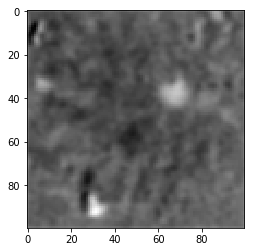

In [2]:
dataset = np.load('/home/kevinteng/Desktop/jpg_to_npy_benchmark/DG13_3-8-17_preprocessed_dF.npy')

#hyperparameter 
NEW_SIZE = 100
ver = '18' #version no.
BATCH_SIZE = 8
lr01 = 0.00001
lr02 = 0.000001
n_neurons = 200
MAX_EPOCHS = 2000
l1_coeff = 0.1
path_desktop = '/home/kevinteng/Desktop/'
#re_list = dataset
re_list = utils.resize(dataset, NEW_SIZE)
IMG_SIZE = re_list.shape[1]

print('Image size: ', IMG_SIZE)
#Dimension for network should include the color channel 
re_list = np.expand_dims(re_list, axis = -1)
#Cast data type to float32 for TensorFlow
# re_list = re_list.astype('float32')
re_list = tf.convert_to_tensor(re_list, dtype = tf.float32)

for img in re_list:
    plt.imshow(np.reshape(img, (IMG_SIZE, IMG_SIZE)), cmap = 'gray')
    plt.show()
    
    break
    
#     if input()=='exit':
#         break

In [3]:
#apply min max norm for mean image
re_list = utils.min_max_norm(re_list)
#max_img_ori = np.expand_dims(max_img_ori, -1)
print('Max value:', np.max(re_list))
print('Min value:', np.min(re_list))


Max value: 1.0
Min value: 0.0


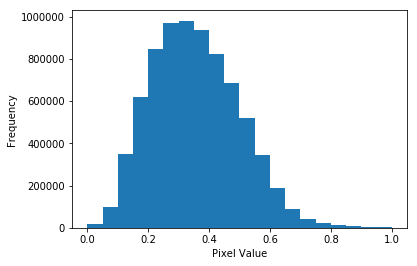

In [4]:
#plot historgram for min max norm image
plt.hist(tf.reshape(re_list, [-1]),20,[0,1])
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

----------------------------------------------------------


# Validation

In [5]:
coords,_, ori_one_hot_imgs = utils_model.create_dat_samples(n_neurons, IMG_SIZE, min_range = 5, 
                                                            max_range = 95, Range = True)
coords = tf.reshape(coords, [n_neurons, 1,1,2])
tf.print(tf.shape(coords))

[200 1 1 2]


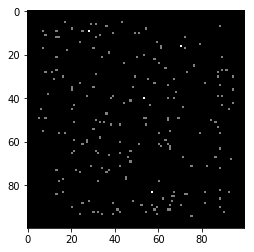

In [6]:
plt.imshow(np.squeeze(np.sum(ori_one_hot_imgs, axis=0)), cmap = 'gray')

-----------------------------------

# Model

In [7]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras.layers import Input, Softmax
from tensorflow.keras.regularizers import l1
from utils_model import conv_block, coordconv_block, up_block, up_coord_block
from tensorflow.keras import layers


def encoder(inps, img_size):
    #downsampling
    coord01 =CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                       filters = 128,strides=(1,1), kernel_size = 3, padding='same'
                       ,activity_regularizer=l1(l1_coeff))(inps)
    act01=tf.keras.layers.ReLU()(coord01)
    pool01=MaxPooling2D((2, 2), strides=2,padding='same')(act01)
    conv01=Conv2D(64, kernel_size = 3, padding='same',activity_regularizer=l1(l1_coeff))(pool01)
    act02=tf.keras.layers.ReLU()(conv01)
    pool02=MaxPooling2D((2, 2), strides=2,padding='same')(act02)
    conv02=Conv2D(32, kernel_size = 3, padding='same',activity_regularizer=l1(l1_coeff))(pool02)
    act03=tf.keras.layers.ReLU()(conv02)
    pool03=MaxPooling2D((2, 2), strides=2,padding='same')(act03)
    
    #upsampling
    x=CoordConv(x_dim = 13, y_dim = 13, with_r = False, 
                filters = 128,strides=(1,1), kernel_size = 3, padding='same',
                activity_regularizer=l1(0.1))(pool03)
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, 3, padding = 'same', activation = 'relu',activity_regularizer=l1(l1_coeff))(x)
    x = UpSampling2D(size=(2,2))(x)
    x = Conv2D(32, 3, padding = 'valid', activation = 'relu',activity_regularizer=l1(l1_coeff))(x)
    x = UpSampling2D(size=(2,2))(x)
    x = Conv2D(16, 3, padding = 'same', activation = 'relu',activity_regularizer=l1(l1_coeff))(x)
    output = Conv2D(1, 3, padding = 'same', activation = 'sigmoid',activity_regularizer=l1(l1_coeff))(x)
    return output


def de_conv(input_tensor):
    coord01 = CoordConv(x_dim = 100, y_dim = 100, with_r = False, filters = 100,
              kernel_size = 1, padding='same', activation='relu')(input_tensor)
    conv01 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(coord01)
    conv02 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv01)
    conv03 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv02)
    conv04 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv03)
    conv05 = Conv2D(filters = 1, kernel_size = 1, strides = 1, padding = "same" )(conv04)
    f1 = Flatten()(conv05)
    output = Softmax(axis = -1)(f1)

    return output

def latent_space(encoded_imgs, deconv_imgs, coords, batch_size, img_size):
    '''
    This function construct the dot product of the output of an encoder(batch_size, img_size, img_size, 1) 
    with the one hot images generated by decoord-conv(n_neurons, img_size, img_size, 1), which yields
    similarity score (batch_size, n_neurons). Similarity score is then concatenate to the last layer of the 
    input coordinates with the corresponding batch (batch_size, n_neurons, 3)
    
    @encoded_imgs: output images from the encoder
    @deconv_imgs: one hot images generated from the coordinate list 
    @coords: A list of coordinates generated randomly based on the number of neurons
    @batch_size: Batch size of the input image for encoder, to allocate size for writing in loop
    
    return: 
        latent space with dim (batch_size, n_neurons, 3, 1)
    '''
    similarity_score = tf.tensordot(encoded_imgs, deconv_imgs, [[1,2,3],[1,2,3]]) #(batch_size, n_neurons)
    squeeze_coords = tf.squeeze(coords/(img_size-1)) #coords dim (n_neurons, 1, 1, 2) = > (n_neurons, 2)
    latent = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    for i in tf.range(batch_size):
        concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[i]), axis=-1)    
        latent = latent.write(i, concat) #(batch_size, n_neurons, 3)
    return tf.expand_dims(latent.stack(), axis = -1), similarity_score

def duplicate_batch(inp_img, batch_size):
    '''
    This function duplicate an image with respect to its batch size
    @param inp_img: input image to be duplicated
    @param batch_size: batch size, which is the number of image to be duplicated

    return duplicated images along axis 0, (batch_size, img_size, img_size, 1)
    '''
    inp_img = tf.expand_dims(inp_img, 0)
    m2 = tf.constant([batch_size, 1, 1, 1], tf.int32)  # multiplier for tiling
    duplicate_imgs = tf.tile(inp_img, m2)
    return duplicate_imgs

def decoder(latent_dim):
    flat_01 = Flatten()(latent_dim)
    dense_01 = Dense(25*25*32, activation = 'relu')(flat_01)
    dense_01 = Reshape((25,25,32))(dense_01)
    up_01 = up_coord_block(dense_01, up_size = 2, x_dim = 50, y_dim = 50, filters = 64, 
                           kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')
    up_02 = up_block(up_01, up_size = 2, filters = 32, kernel_size = 3,
                            strides = 1, padding = 'same', activation = 'relu')
    output = Conv2D(filters = 1, kernel_size = 3, strides = 1,
                    padding = 'same', activation = None)(up_02)
    return output

class learnable_coords(layers.Layer):
    def __init__(self, coords):
        super(learnable_coords, self).__init__()
        self.learned_coords = tf.Variable((coords), trainable = True)

    def __call__(self, img_size):
        y = self.learned_coords/(img_size-1) #normalize the coordinates
    #         y = tf.clip_by_value(y, clip_value_min=0, clip_value_max=1) #clip values
        return y

In [8]:
# def encoder02(inps, img_size):
#     #1st block
#     coord01 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
#                         filters = 256, kernel_size = 3, padding='same')(inps)
#     leaky01 =tf.keras.layers.LeakyReLU(0.5)(coord01)
#     conv01 = Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = "same", activation = 'relu')(leaky01 )
#     leaky02 = tf.keras.layers.LeakyReLU(0.5)(conv01)
#     output = Conv2D(1, kernel_size = 3,activation = 'linear', padding='same')(leaky02 )
#     return output

-----------------------------------------------------------------

## Build Model

In [9]:
#build encoder 
inps = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
encoder_model = Model(inps, encoder(inps, IMG_SIZE))

#build coord model
inp = Input(shape=(100, 100,2)) #(batch_size, img_size, img_size, 2)
de_coordconv = Model(inp, de_conv(inp))
de_coordconv.load_weights("best_class_model100_02.hdf5")

#decoder
latent_dim = Input(shape=(n_neurons, 3, 1))
decoder_model = Model(latent_dim, decoder(latent_dim))

#learnable coords
l_coords = learnable_coords(coords)

## Train Model

--------------------------------------

In [10]:
#optimizer 
opt_global = tf.keras.optimizers.Adam(lr01)
opt_encoded_onehot = tf.keras.optimizers.Adam(lr02)
#loss function 
mse = tf.losses.MeanSquaredError()
@tf.function
def train_fn(inp_imgs, coords, img_size, batch_size, neuron_multi = True):
    with tf.GradientTape(persistent=True) as tape:
        #--RHS pipeline (Learnable Coords)--
        #custom layer for updating coordinates
        updated_coords = l_coords(img_size)
        m1 = tf.constant([1,img_size,img_size,1], tf.int32) #multiplier for tiling 
        #tile coordinates (n_neurons, img_size, img_size, 1)
        tile_cd = tf.tile(updated_coords, m1)
        #de-coordconv model
        de_coordconv.trainable = False #freeze de-coordconv
        one_hot_imgs = tf.reshape(de_coordconv(tile_cd),[-1,img_size, img_size, 1]) #(n_neurons, img_size, img_size, 1)
        
        #--LHS pipeline (Encoder Pipeline)--
        #output from encoder (batch_size, img_size, img_size, 1)
        encoder_output = encoder_model(inp_imgs)
        
        #--Bottle Neck--
        #latent space
        latent, similarity_score = latent_space(encoder_output, one_hot_imgs, coords, batch_size, img_size)#(batch_size, n_neurons, 3, 1)
        #compute the mse between the neurons with the one hot images generated by the deconv
        if not neuron_multi:
            #sum one hot images for all neurons, (n_neurons, img_size, img_size, 1) => (img_size, img_size, 1)
            one_hot_sum = tf.math.reduce_sum(one_hot_imgs, 0)
            #duplicate summed one_hot_images and compare with encoded output 
            #(img_size, img_size, 1) => (batch_size, img_size, img_size, 1) 
            duplicated_one_hot = duplicate_batch(one_hot_sum, batch_size)
            #loss between the encoded output and the one hot images 
            encoded_one_loss = mse(encoder_output, duplicated_one_hot)
        #compute the mse between the neurons with one hot images multiplied by similarity scores
        else:
            #multiply similarity scores with one hot images
            #(batch_size, n_neurons, img_size, img_size,1)
            similarity_multi = tf.einsum('ij,jklm->ijklm', similarity_score, one_hot_imgs) 
            #(batch_size, img_size, img_size, 1)
            similarity_multi_reduced_neurons = tf.reduce_sum(similarity_multi, axis=1)
            #threshold multiplied similarity scores with one hot images
            similarity_multi_threshold = tf.where(similarity_multi_reduced_neurons<0.7, 0.0, similarity_multi_reduced_neurons)
            #loss between the encoded output and the one hot images 
            encoded_one_loss = mse(encoder_output, similarity_multi_threshold)
            
        #--Decoder--
        #reconstruction 
        reconstruction = decoder_model(latent)  
        #--Loss--
        #the loss that backprop through the whole pipeline 
        global_loss = mse(inp_imgs, reconstruction)
        #regularizer loss
        regularizer_loss = tf.math.reduce_sum(encoder_model.losses)
        #append loss 
        loss = [global_loss, encoded_one_loss, regularizer_loss]
    
    #back prop through encoder + decoder + learnable_coords
    varis_global = encoder_model.trainable_variables + decoder_model.trainable_variables + l_coords.trainable_variables
    grad_model = tape.gradient(global_loss, varis_global)
    opt_global.apply_gradients(zip(grad_model, varis_global))
    
    #back prop through encoder + learnable_coords
    varis_encoded_one = encoder_model.trainable_variables + l_coords.trainable_variables
    grad_partial = tape.gradient(encoded_one_loss, varis_encoded_one)
    opt_encoded_onehot.apply_gradients(zip(grad_partial, varis_encoded_one))
    
    grad = [grad_model, grad_partial]
    return loss, updated_coords, one_hot_imgs, encoder_output, similarity_score, reconstruction, grad

In [11]:
# ds_dir = '/home/kevinteng/Desktop/jpg_to_npy_benchmark/'

# for d in sorted(os.listdir(ds_dir)):
#     merge_d = os.path.join(ds_dir+d)
#     imgs = dataset_parse(merge_d, 100)
#     break

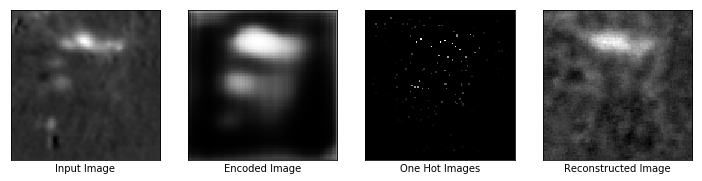

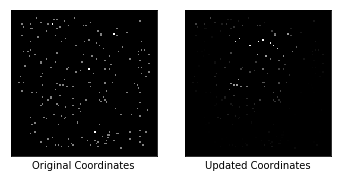

Epochs: 100, Reconstruction Loss: 0.0025309098418802023
Regularizer Loss: 34775.1171875, Total Loss: 34775.12109375
Similarity Loss: 0.2114749699831009
Max Similarity scores: 0.9600480198860168
Updated Coordinates: [[[0.8686852  0.67676765]]]
Gradient global min:-0.0007864962099120021, max:0.001155773876234889
Gradient partial min:-0.05780814215540886, max:0.1777396947145462



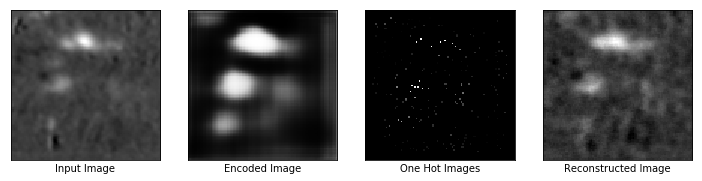

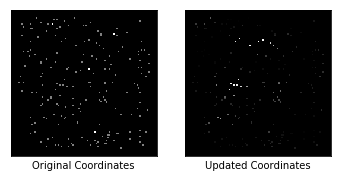

Epochs: 200, Reconstruction Loss: 0.0013050107518211007
Regularizer Loss: 35432.3203125, Total Loss: 35432.3203125
Similarity Loss: 0.13412223756313324
Max Similarity scores: 0.9840975403785706
Updated Coordinates: [[[0.8686852  0.67676765]]]
Gradient global min:-0.000557807506993413, max:0.0005284502985887229
Gradient partial min:-0.0327114574611187, max:0.09507357329130173



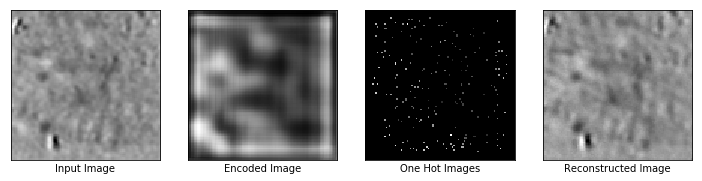

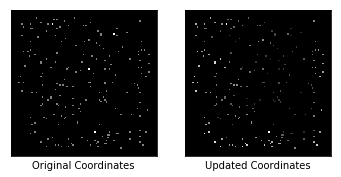

Epochs: 300, Reconstruction Loss: 0.0009559374884702265
Regularizer Loss: 31435.6328125, Total Loss: 31435.6328125
Similarity Loss: 0.0836230143904686
Max Similarity scores: 0.7616674900054932
Updated Coordinates: [[[0.86868584 0.67676765]]]
Gradient global min:-0.0023893241304904222, max:0.002928761998191476
Gradient partial min:-0.027011515572667122, max:0.048181671649217606



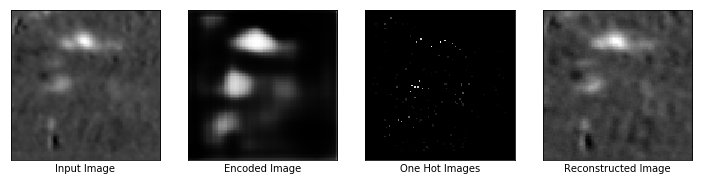

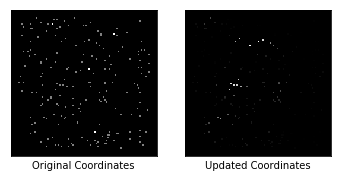

Epochs: 400, Reconstruction Loss: 0.0008824706892482936
Regularizer Loss: 29421.916015625, Total Loss: 29421.916015625
Similarity Loss: 0.05470618978142738
Max Similarity scores: 0.8966959118843079
Updated Coordinates: [[[0.8686858  0.67676765]]]
Gradient global min:-0.00226772902533412, max:0.0013895260635763407
Gradient partial min:-0.027942322194576263, max:0.03481446951627731



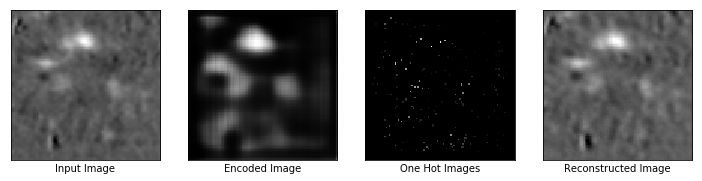

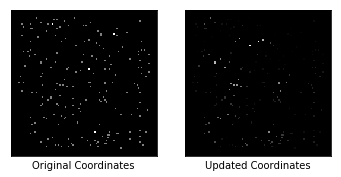

Epochs: 500, Reconstruction Loss: 0.0007023144280537963
Regularizer Loss: 32165.638671875, Total Loss: 32165.638671875
Similarity Loss: 0.03697691112756729
Max Similarity scores: 0.7784976959228516
Updated Coordinates: [[[0.8686862  0.67676765]]]
Gradient global min:-0.0007521893712691963, max:0.0004981774836778641
Gradient partial min:-0.025206726044416428, max:0.02951139584183693



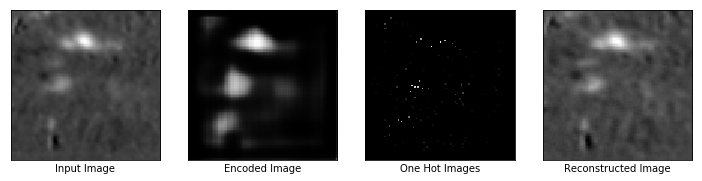

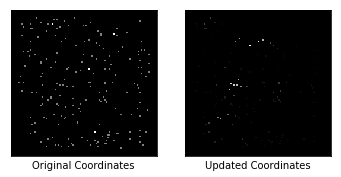

Epochs: 600, Reconstruction Loss: 0.0006133084534667432
Regularizer Loss: 33349.265625, Total Loss: 33349.265625
Similarity Loss: 0.028370629996061325
Max Similarity scores: 0.746429443359375
Updated Coordinates: [[[0.8686841  0.67676765]]]
Gradient global min:-0.0024633058346807957, max:0.0014456197386607528
Gradient partial min:-0.026127973571419716, max:0.03231597691774368



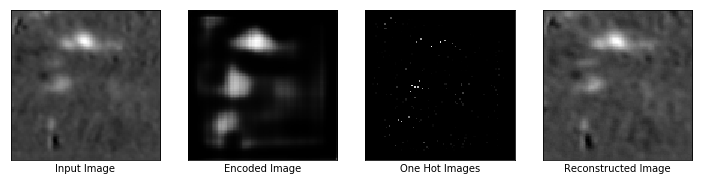

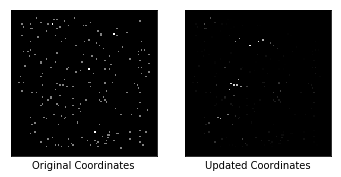

Epochs: 700, Reconstruction Loss: 0.0005258827586658299
Regularizer Loss: 36644.78125, Total Loss: 36644.78125
Similarity Loss: 0.023902367800474167
Max Similarity scores: 0.6716427206993103
Updated Coordinates: [[[0.868681   0.67676765]]]
Gradient global min:-0.0014541677664965391, max:0.0011828510323539376
Gradient partial min:-0.025413766503334045, max:0.03447868302464485



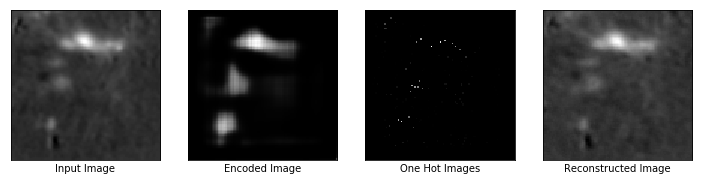

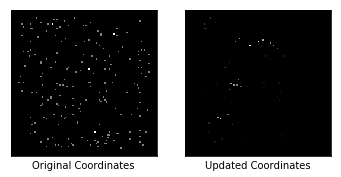

Epochs: 800, Reconstruction Loss: 0.0005388492136262357
Regularizer Loss: 39560.1640625, Total Loss: 39560.1640625
Similarity Loss: 0.020913828164339066
Max Similarity scores: 0.5918707251548767
Updated Coordinates: [[[0.86868006 0.67676765]]]
Gradient global min:-0.0011719088070094585, max:0.00145324831828475
Gradient partial min:-0.024661263450980186, max:0.033377617597579956



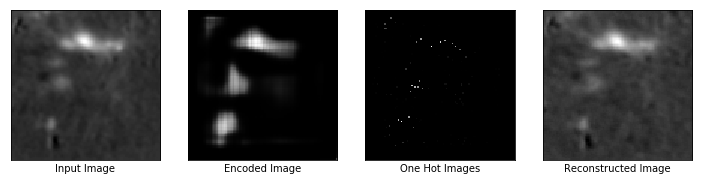

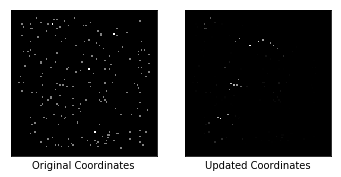

Epochs: 900, Reconstruction Loss: 0.0006164998630993068
Regularizer Loss: 42905.32421875, Total Loss: 42905.32421875
Similarity Loss: 0.02181541733443737
Max Similarity scores: 0.538248598575592
Updated Coordinates: [[[0.86867225 0.67676824]]]
Gradient global min:-0.0022689432371407747, max:0.002011706121265888
Gradient partial min:-0.025190310552716255, max:0.03141341730952263



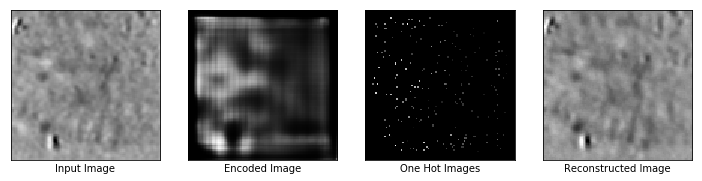

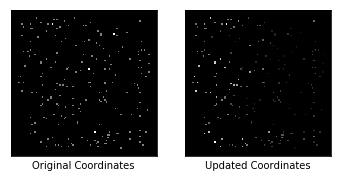

Epochs: 1000, Reconstruction Loss: 0.001330473693087697
Regularizer Loss: 46700.234375, Total Loss: 46700.234375
Similarity Loss: 0.026164639741182327
Max Similarity scores: 0.67536461353302
Updated Coordinates: [[[0.86867005 0.67676824]]]
Gradient global min:-0.006101598031818867, max:0.005746462848037481
Gradient partial min:-0.03012048825621605, max:0.03937248885631561



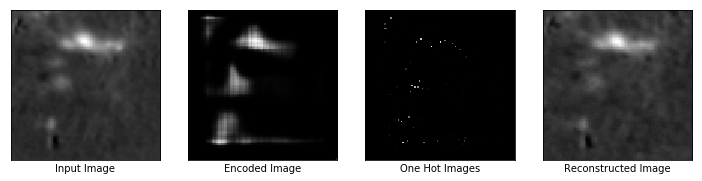

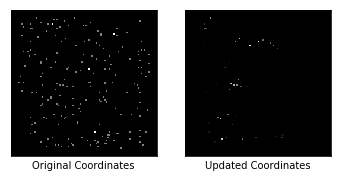

Epochs: 1100, Reconstruction Loss: 0.000634611991699785
Regularizer Loss: 53875.21875, Total Loss: 53875.21875
Similarity Loss: 0.025601083412766457
Max Similarity scores: 0.5441237688064575
Updated Coordinates: [[[0.86867005 0.67676824]]]
Gradient global min:-0.0028489194810390472, max:0.001705577247776091
Gradient partial min:-0.03526167944073677, max:0.04827554523944855



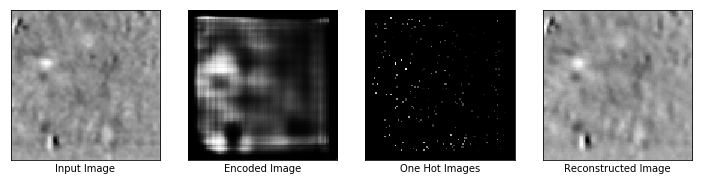

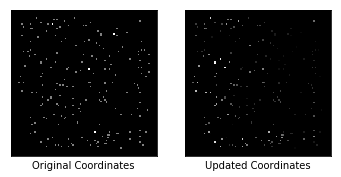

Epochs: 1200, Reconstruction Loss: 0.000624929612968117
Regularizer Loss: 64470.8671875, Total Loss: 64470.8671875
Similarity Loss: 0.031868286430835724
Max Similarity scores: 0.8418976068496704
Updated Coordinates: [[[0.8686681  0.67676824]]]
Gradient global min:-0.004017743282020092, max:0.0034917094744741917
Gradient partial min:-0.049364253878593445, max:0.058386631309986115



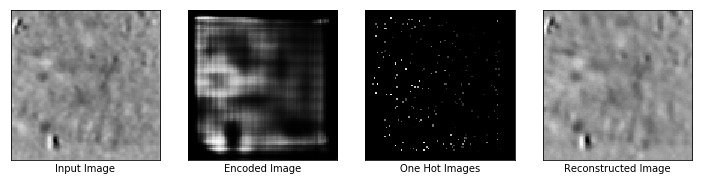

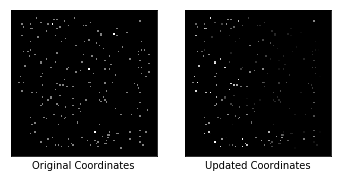

Epochs: 1300, Reconstruction Loss: 0.00048386925482191145
Regularizer Loss: 93897.9765625, Total Loss: 93897.9765625
Similarity Loss: 0.03323231264948845
Max Similarity scores: 0.7140466570854187
Updated Coordinates: [[[0.86866516 0.67676824]]]
Gradient global min:-0.0005993670783936977, max:0.000639486825093627
Gradient partial min:-0.054133180528879166, max:0.06769963353872299



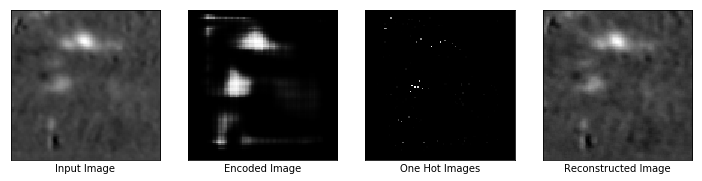

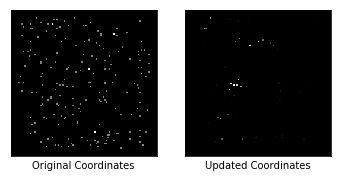

Epochs: 1400, Reconstruction Loss: 0.0007633889326825738
Regularizer Loss: 140176.90625, Total Loss: 140176.90625
Similarity Loss: 0.032233480364084244
Max Similarity scores: 0.8840298652648926
Updated Coordinates: [[[0.86864704 0.67676824]]]
Gradient global min:-0.0021690193098038435, max:0.0010747804772108793
Gradient partial min:-0.050947077572345734, max:0.05642616003751755



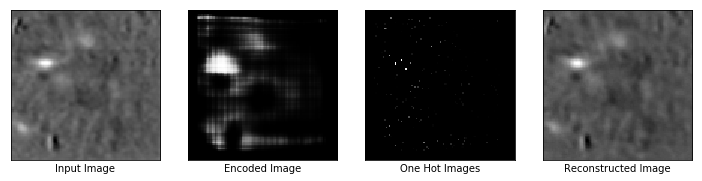

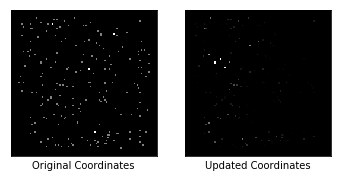

Epochs: 1500, Reconstruction Loss: 0.0005765585228800774
Regularizer Loss: 202726.921875, Total Loss: 202726.921875
Similarity Loss: 0.04064561054110527
Max Similarity scores: 0.9765048027038574
Updated Coordinates: [[[0.86864126 0.6767684 ]]]
Gradient global min:-0.003609867300838232, max:0.005349467042833567
Gradient partial min:-0.059087131172418594, max:0.06424583494663239



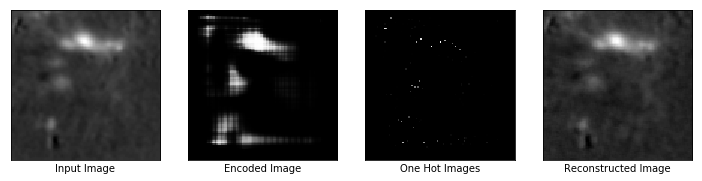

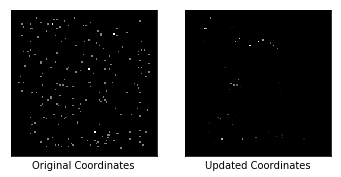

Epochs: 1600, Reconstruction Loss: 0.0007022515055723488
Regularizer Loss: 261187.0625, Total Loss: 261187.0625
Similarity Loss: 0.05560910701751709
Max Similarity scores: 0.9705399870872498
Updated Coordinates: [[[0.8686371 0.6767684]]]
Gradient global min:-0.0012349879834800959, max:0.0010957570048049092
Gradient partial min:-0.07457907497882843, max:0.07881520688533783



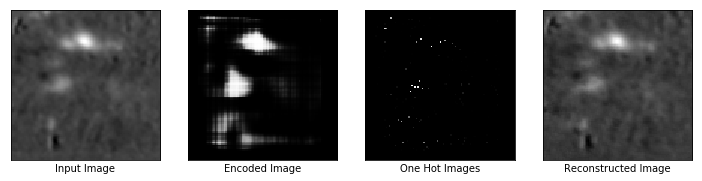

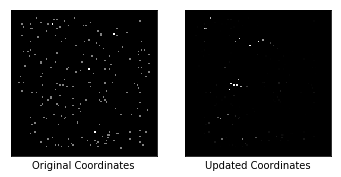

Epochs: 1700, Reconstruction Loss: 0.0005478947423398495
Regularizer Loss: 292482.21875, Total Loss: 292482.21875
Similarity Loss: 0.059246741235256195
Max Similarity scores: 0.9828243255615234
Updated Coordinates: [[[0.8686036 0.6767684]]]
Gradient global min:-0.0011782532092183828, max:0.0010154650080949068
Gradient partial min:-0.0741838663816452, max:0.07430601119995117



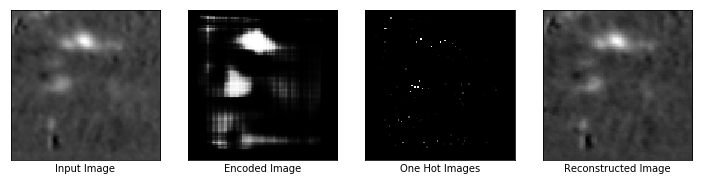

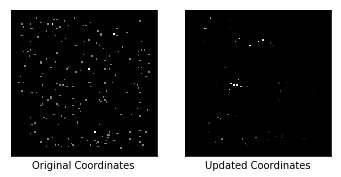

Epochs: 1800, Reconstruction Loss: 0.0004293443344067782
Regularizer Loss: 295970.8125, Total Loss: 295970.8125
Similarity Loss: 0.0775335356593132
Max Similarity scores: 0.9949815273284912
Updated Coordinates: [[[0.868595 0.676767]]]
Gradient global min:-0.00033240410266444087, max:0.0005295685841701925
Gradient partial min:-0.07526518404483795, max:0.08264117687940598



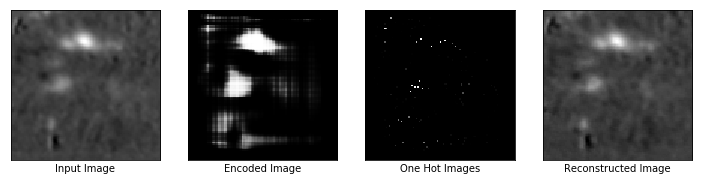

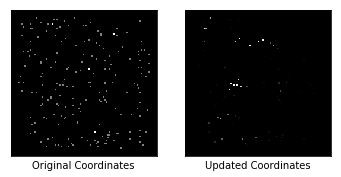

Epochs: 1900, Reconstruction Loss: 0.0005265066283755004
Regularizer Loss: 295127.75, Total Loss: 295127.75
Similarity Loss: 0.08652693033218384
Max Similarity scores: 0.9983531832695007
Updated Coordinates: [[[0.8685937 0.6767671]]]
Gradient global min:-0.00104499701410532, max:0.0003128480166196823
Gradient partial min:-0.08468515425920486, max:0.10320190340280533



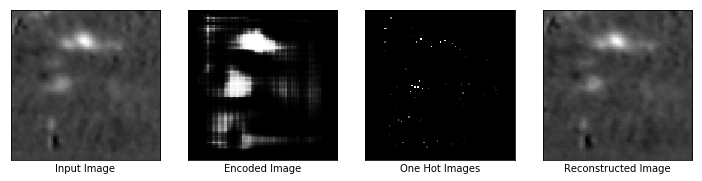

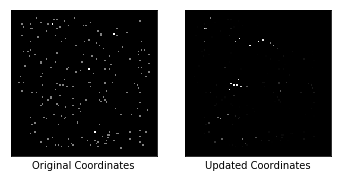

Epochs: 2000, Reconstruction Loss: 0.0004177390947006643
Regularizer Loss: 300757.0, Total Loss: 300757.0
Similarity Loss: 0.08514652401208878
Max Similarity scores: 0.9994775652885437
Updated Coordinates: [[[0.86859286 0.6767671 ]]]
Gradient global min:-0.0010664027649909258, max:0.001204031752422452
Gradient partial min:-0.08549465239048004, max:0.11116555333137512


In [12]:
batch_imgs= tf.data.Dataset.from_tensor_slices(re_list).batch(BATCH_SIZE, drop_remainder=True)

#list to be append to output 
loss_list_global = []
loss_list_encoded_one_hot = []
regulariser_loss_list = []
input_imgs = []
coords_list = []
encoded_imgs = []
reconstructed_imgs = []
one_hot_imgs_list = []
similarity_list = []

captions_01 = ['Input Image', 'Encoded Image', 'One Hot Images','Reconstructed Image']
captions_02 = ['Original Coordinates', 'Updated Coordinates']

#list to append to monitor each frames for the last epochs 
one_hot_imgs_last_list = []
encoder_output_last_list = []
similarity_score_last_list = []
reconstruction_last_list = []

epochs = 1
while epochs <= MAX_EPOCHS:
    #reset coords for each epochs
#     coords,_, ori_one_hot_imgs = create_dat_samples(n_neurons)
#     coords = tf.reshape(coords, [n_neurons, 1,1,2])
    for steps, batched_imgs in enumerate(batch_imgs):
        loss, updated_coords, one_hot_imgs, encoder_output, similarity_score, reconstruction, grad = train_fn(batched_imgs, coords, IMG_SIZE, BATCH_SIZE)
        #append all frames for final epochs!
        if epochs==MAX_EPOCHS:
            one_hot_imgs_last_list.append(one_hot_imgs)
            encoder_output_last_list.append(encoder_output)
            similarity_score_last_list.append(similarity_score)
            reconstruction_last_list.append(reconstruction)
    #loss is append for each epochs
    loss_list_global.append(loss[0])
    loss_list_encoded_one_hot.append(loss[1])
    regulariser_loss_list.append(loss[-1])
    
    rand = randint(0, BATCH_SIZE-1) #random number to generate for plotting outputs 
    if epochs%100==0:
        img_row01 = [batched_imgs[rand], encoder_output[rand], similarity_multi(n_neurons, one_hot_imgs, similarity_score[rand], IMG_SIZE), reconstruction[rand]]
        img_row02 = [stack4plot(ori_one_hot_imgs), similarity_multi(n_neurons, one_hot_imgs, similarity_score[rand], IMG_SIZE)]
        plot_comparison(img_row01, captions_01, n_col=len(img_row01), figsize = (10, 10))
        plot_comparison(img_row02, captions_02, n_col=len(img_row02))
        print("Epochs: {}, Reconstruction Loss: {}".format(epochs, loss[0].numpy()))
        print("Regularizer Loss: {}, Total Loss: {}".format(loss[-1].numpy(), loss[0].numpy()+loss[-1].numpy()))
        print("Similarity Loss: {}".format(loss[1].numpy()))
        print("Max Similarity scores: {}".format(np.max(similarity_score[rand])))
        print("Updated Coordinates: {}".format(updated_coords[0]))
        print("Gradient global min:{}, max:{}".format(np.min(grad[0][rand]), np.max(grad[0][rand])))
        print("Gradient partial min:{}, max:{}".format(np.min(grad[1][0]), np.max(grad[1][0])))
    #append list for every 100 epochs 
#     if epochs%100==0:
        encoded_imgs.append(encoder_output)
        input_imgs.append(batched_imgs)
        coords_list.append(updated_coords)
        reconstructed_imgs.append(reconstruction)
        one_hot_imgs_list.append(one_hot_imgs)
        similarity_list.append(similarity_score)
        
    epochs+=1

----

# Save Output Data

In [13]:
save_list = [loss_list_global, loss_list_encoded_one_hot, input_imgs, coords_list, encoded_imgs, reconstructed_imgs, one_hot_imgs_list, similarity_list]
save_names = ['loss_list_global', 'loss_list_encoded_one_hot', 'input_imgs', 'coords_list', 'encoded_imgs', 'reconstructed_imgs', 'one_hot_imgs_list', 'similarity_list']

directory = '/home/kevinteng/Desktop/npy/{}'.format(ver)
#make directory to save
if not os.path.exists(directory):
    os.makedirs(directory)
    
for names, items in zip(save_names, save_list):
    tensor = tf.convert_to_tensor(items, tf.float32)
    np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, names, ver), np.array(tensor))
    

In [14]:
#save coords and one hot images()
np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_coords', ver), np.array(coords))
np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_one_hot_imgs', ver), np.array(ori_one_hot_imgs))

In [15]:
#save info for every frames in last epochs
save_list_last = [encoder_output_last_list, similarity_score_last_list, reconstruction_last_list]
save_names_last = ['encoder_output_last_list', 'similarity_score_last_list', 'reconstruction_last_list']

for names, items in zip(save_names_last, save_list_last):
    aggregate_tensor = utils.concat_batch(items)
    np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, names, ver), np.array(aggregate_tensor))

In [16]:
#save one hot imgs for last epochs 
tensor = tf.convert_to_tensor(one_hot_imgs_last_list, tf.float32) #(frames/batch, n_neurons, img_size, img_size, 1)
np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_last_list', ver), np.array(tensor))

In [17]:
#save weights
encoder_model.save_weights('model_weights/encoder_model_{}.h5'.format(ver))
decoder_model.save_weights('model_weights/decoder_model_{}.h5'.format(ver))

---

# Visualization

In [18]:
# coords list for every 100 epochs (max_epochs/100, n_neurons, 1, 1, 2)
coords_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'coords_list', ver)) 
# encoder output first batch for every 100 epochs (max_epochs/100, 8, 100, 100, 1)
encoded_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'encoded_imgs', ver))
# input image first batch for every 100 epochs (max_epochs/100, 8, 100, 100, 1)
input_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'input_imgs', ver))
# global loss for every epochs
loss_list_global_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'loss_list_global', ver))
#similarity loss for every epochs
loss_list_encoded_one_hot_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'loss_list_encoded_one_hot', ver))
# one hot images first batch for every 100 epochs  (max_epochs/100, n_neurons, 100, 100, 1)
one_hot_imgs_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_list', ver))
# reconstructed images first batch for every 100 epochs (max_epochs/100, 8, 100, 100, 1)
reconstructed_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'reconstructed_imgs', ver))
# similarity batch for every 100 epochs (max_epochs/100, 8, n_neurons)
similarity_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'similarity_list', ver))
#original coords list (n_neurons, 1, 1, 2)
ori_coords_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_coords', ver))
#original one hot image (n_neurons, 100, 100, 1)
ori_one_hot_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_one_hot_imgs', ver))

In [19]:
#load roi mask
roi_img = np.load('/home/kevinteng/Desktop/Manual_annotation/DG-13-3-8-17_ROImask.npy')
roi_img = cv2.resize(roi_img, (100, 100))
# plt.imshow(roi_img, cmap = 'gray')

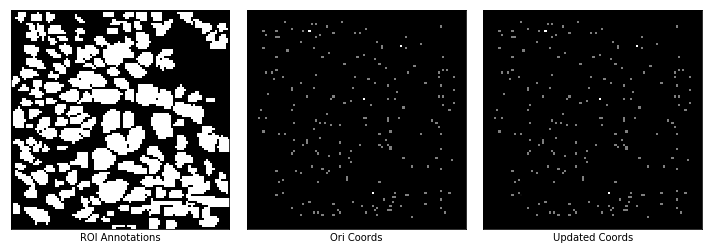

In [20]:
#comparison of roi and one hot images 
captions_03 = ['ROI Annotations', 'Ori Coords', 'Updated Coords']
img_row03 = [roi_img, stack4plot(ori_one_hot_imgs_npy), stack4plot(one_hot_imgs_list_npy[-1])]
plot_comparison(img_row03, captions_03, n_col=len(img_row03), figsize = (10, 10))

Mean value:  0.020000001
Counts:  196


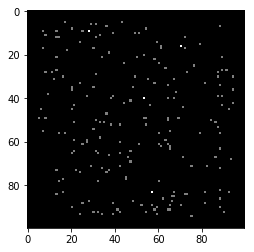

In [21]:
sum_updated_coords = stack4plot(one_hot_imgs_list_npy[-1])
print("Mean value: ", np.mean(sum_updated_coords))
updated_coords_img = np.where(sum_updated_coords<0.1, 0, sum_updated_coords) 
activations_count = np.count_nonzero(updated_coords_img!=0)
print("Counts: ", activations_count)
plt.imshow(updated_coords_img, cmap = 'gray')

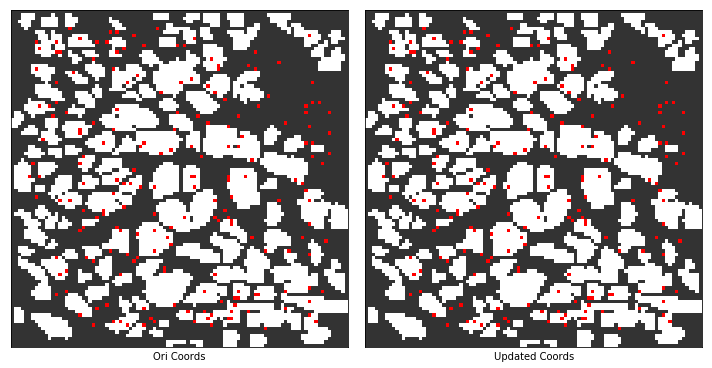

In [22]:
#define color
col = [(0.2, 0.2, 0.2),(1,1,1),(1,0,0)] 
cm = LinearSegmentedColormap.from_list('mylist', col, 3)  
#     #Bins for cmap
bounds=[0,1,5,10]
norm = BoundaryNorm(bounds, cm.N)
#overlap mask with original coordinates 
roi_ori_mask = overlapMasks02(roi_img, stack4plot(ori_one_hot_imgs_npy))

#overlap mask with updated coordinates 
roi_updated_mask = overlapMasks02(roi_img, updated_coords_img)

captions_04 = ['Ori Coords', 'Updated Coords']
img_row04 = [roi_ori_mask, roi_updated_mask]
plot_comparison(img_row04, captions_04, n_col=len(img_row04), figsize = (10, 10), cmap = cm, norm = norm)

In [23]:
#confusion matrix 
confMatrix = utils_model.getConfusionMatrix(roi_img, updated_coords_img)

print("True Positives: ", confMatrix[0])
print("True Negatives: ", confMatrix[1])
print("False Positive Ratio: ", confMatrix[2])
print("False Negatives Ratio: ", confMatrix[3])
print("F1 score: ", utils_model.f1score(confMatrix))

True Positives:  0.0102
True Negatives:  0.0094
False Positive Ratio:  0.4084
False Negatives Ratio:  0.5720000000000001
F1 score:  0.04655408489274305


---

# Similarity Scores with Threshold

In [26]:
neuron_activations, neuron_activations_thr = similarity_multiplication(similarity_list_npy, one_hot_imgs_list_npy, 
                                                                       n_neurons, epoch_pos=-1, 
                                                                       img_size = IMG_SIZE, threshold = 0.7)

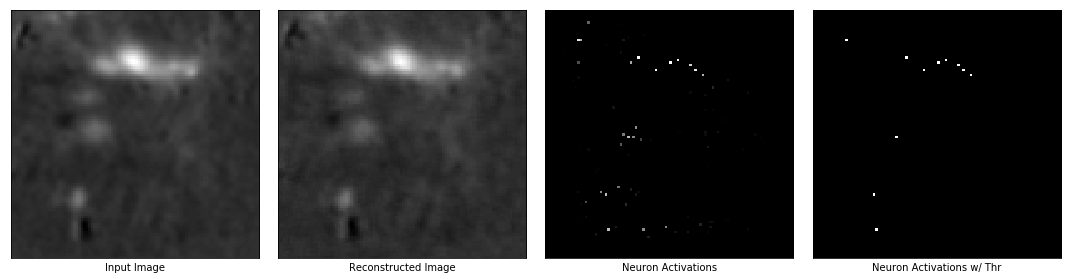

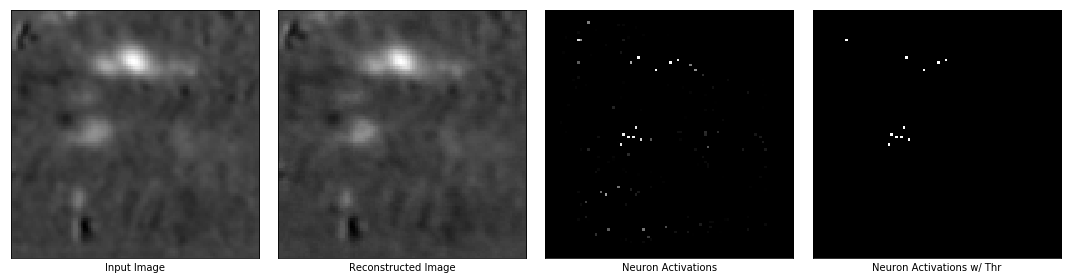

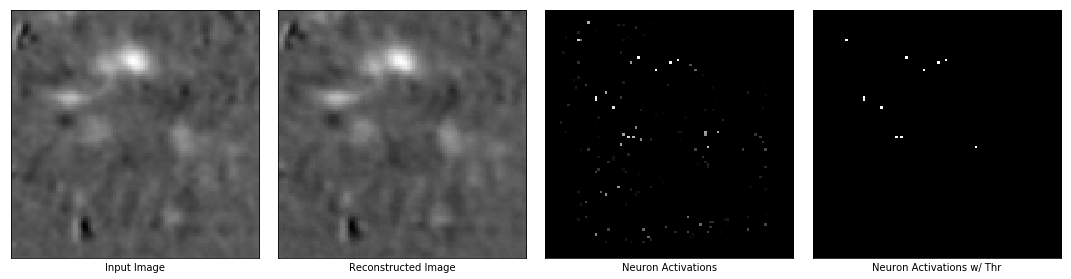

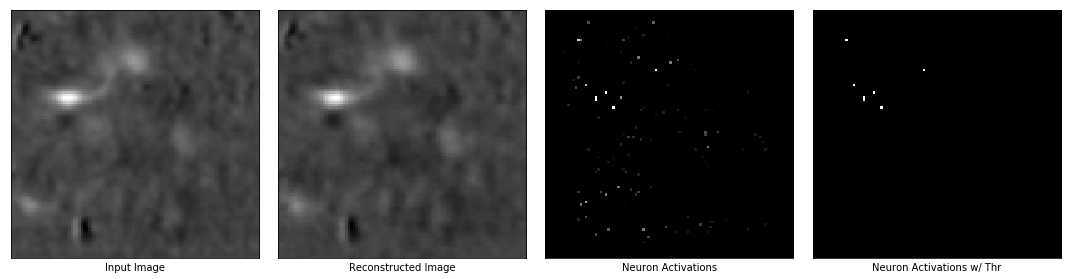

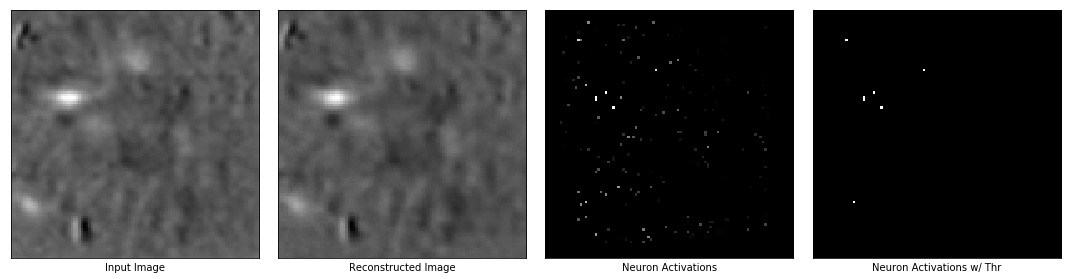

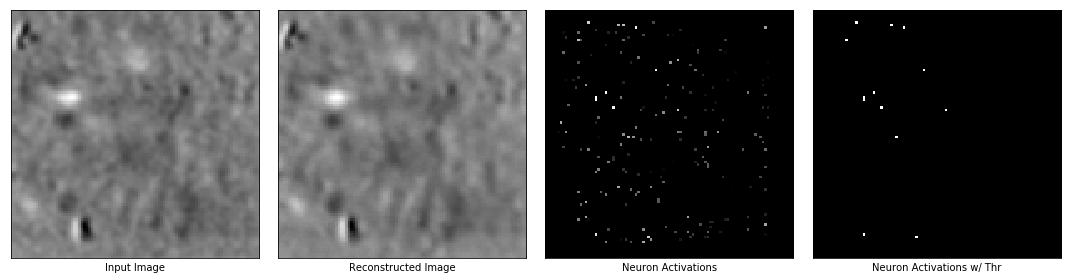

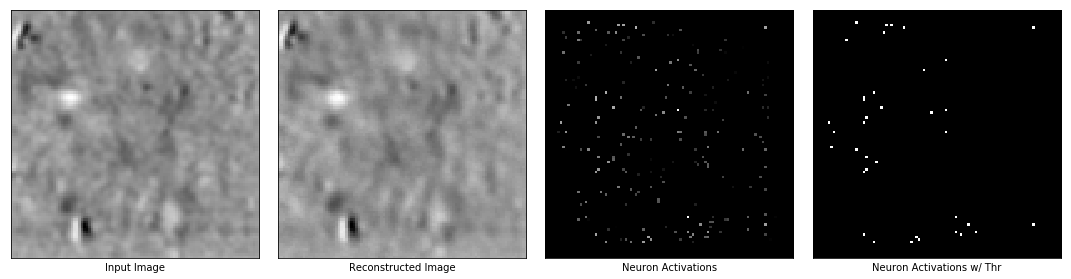

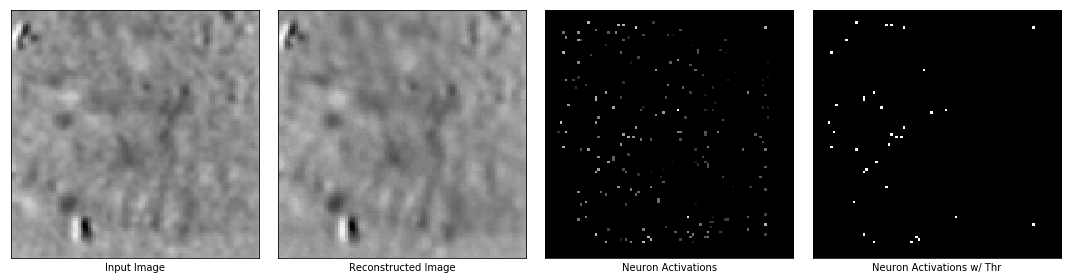

In [27]:
batch_size = BATCH_SIZE
captions_03 = ['Input Image', 'Reconstructed Image','Neuron Activations', 'Neuron Activations w/ Thr']
for i in range(batch_size):
    img_row03 = [np.squeeze(input_imgs_npy[-1,i]), np.squeeze(reconstructed_imgs_npy[-1,i]), neuron_activations[i], neuron_activations_thr[i]]
    plot_comparison(img_row03, captions_03, n_col=len(img_row03), figsize = (15, 15))

## Loss Plot

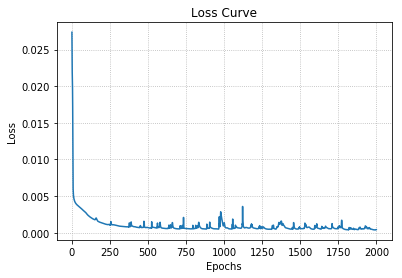

In [28]:
#plot loss
xlabel = 'Epochs'
ylabel = 'Loss'
title = 'Loss Curve'
utils_vis.plot_loss(loss_list_global_npy, xlabel, ylabel, title)

## Feature Maps

In [29]:
#build encoder 
inps = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
encoder_model = Model(inps, encoder(inps, IMG_SIZE))
encoder_model.load_weights("model_weights/encoder_model_{}.h5".format(ver))
#build coord model
inp = Input(shape=(100, 100,2)) #(batch_size, img_size, img_size, 2)
de_coordconv = Model(inp, de_conv(inp))
de_coordconv.load_weights("best_class_model100_02.hdf5")

#decoder
latent_dim = Input(shape=(n_neurons, 3, 1))
decoder_model = Model(latent_dim, decoder(latent_dim))
decoder_model.load_weights("model_weights/decoder_model_{}.h5".format(ver))

#learnable coords
l_coords = learnable_coords(ori_coords_npy)

In [30]:
decoder_layers_name = utils_vis.layers_name(decoder_model) 

input_6
flatten_3
dense_1
reshape_1
up_sampling2d_8
coord_conv_9
activation_2
up_sampling2d_9
conv2d_36
activation_3
conv2d_37


In [31]:
#concat latent space as input
squeeze_coords = np.squeeze(coords_list_npy[-1]) #use the last pos
similarity_score = similarity_list_npy[-1]


concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[0]), axis=-1)
concat_ex = concat[np.newaxis,:,:,np.newaxis] #extand axis=0 and axis=-1 for input into model
print(concat_ex.shape)

(1, 200, 3, 1)


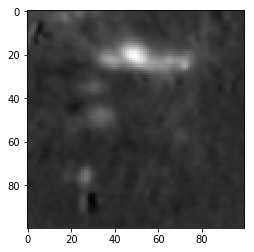

In [32]:
plt.imshow(np.squeeze(input_imgs_npy[-1,0]), cmap = 'gray')

Shape of feature maps: (1, 50, 50, 64)
Number of feature maps in layer:  64


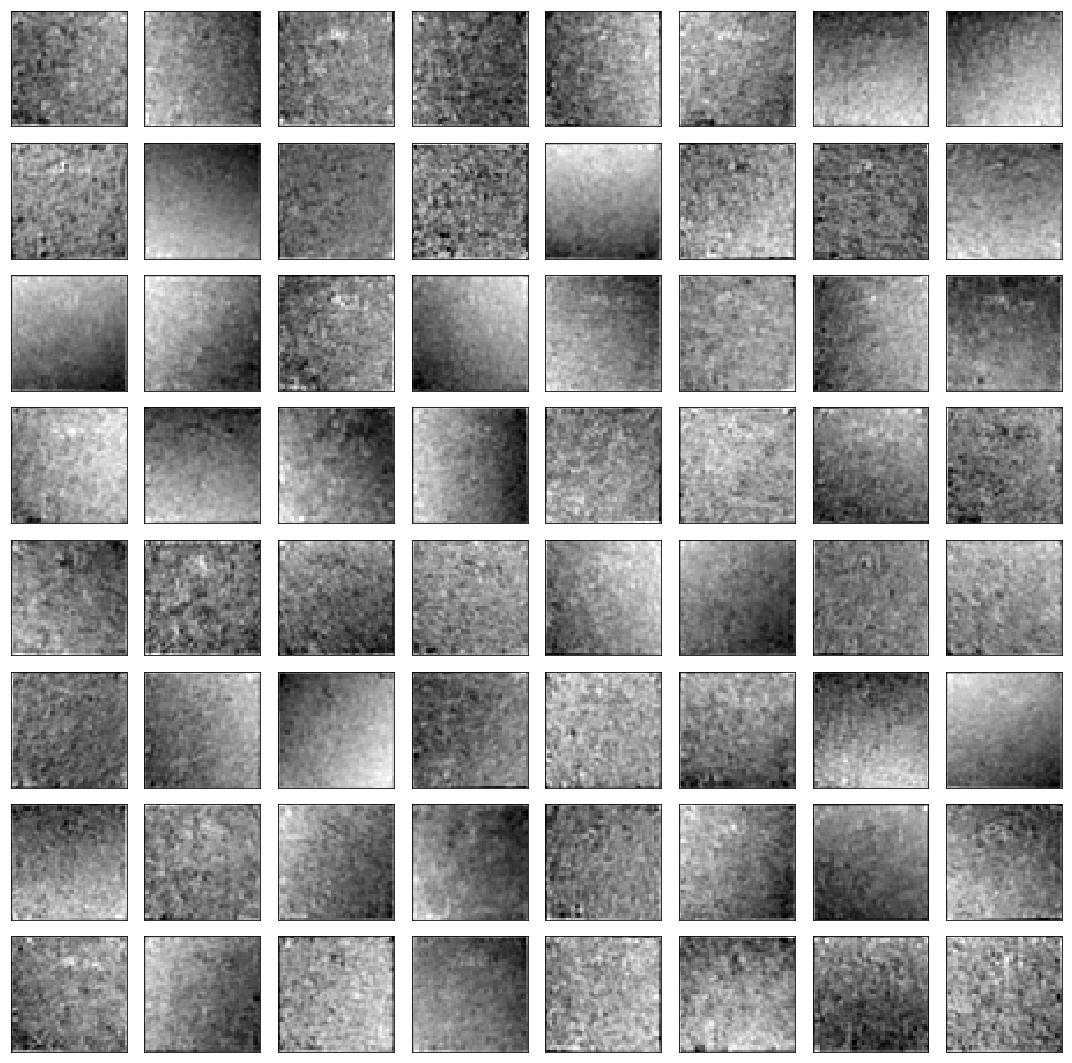

In [33]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'coord_conv_9', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 8, 8, figsize=(15,15))

Shape of feature maps: (1, 100, 100, 32)
Number of feature maps in layer:  32


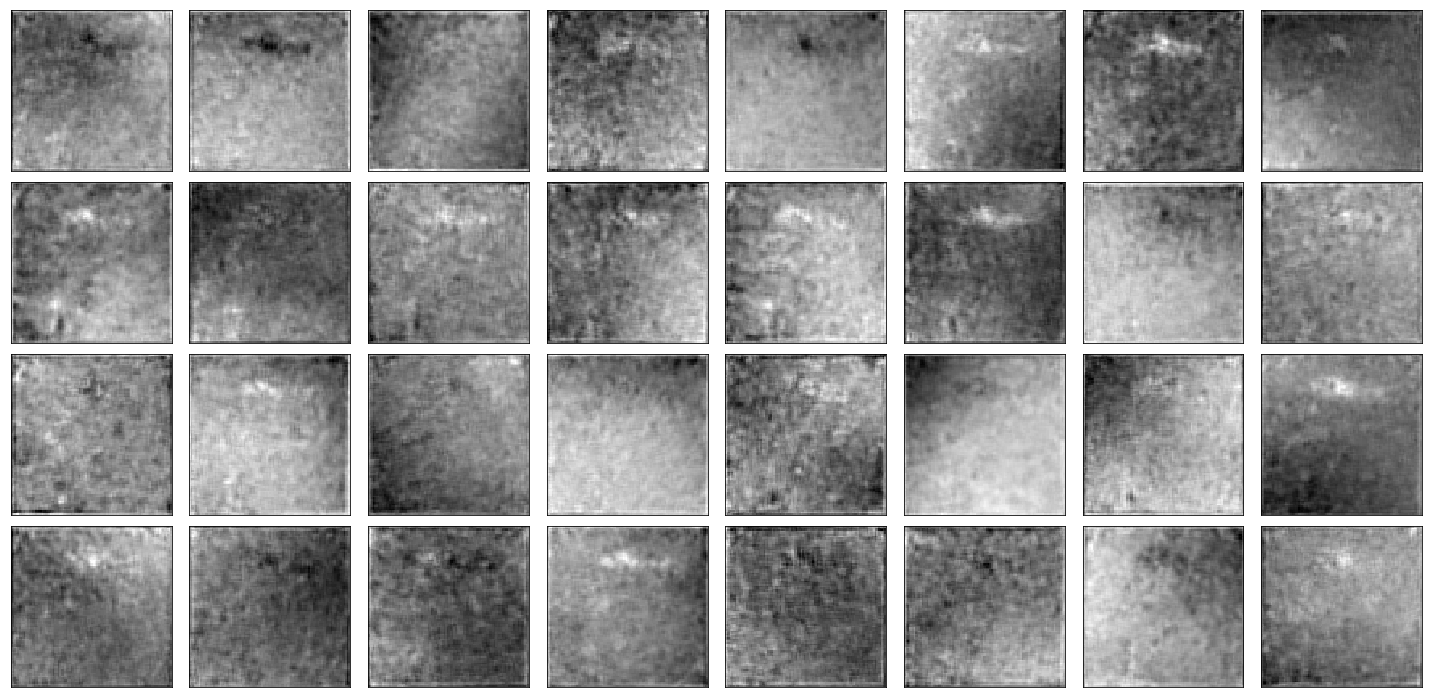

In [34]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'conv2d_36', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 4, 8, figsize=(20,10))

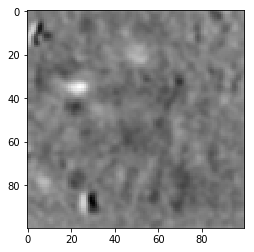

In [35]:
plt.imshow(np.squeeze(input_imgs_npy[-1,5]), cmap = 'gray')

In [36]:
#concat latent space as input
squeeze_coords = np.squeeze(coords_list_npy[-1]) #use the last pos
similarity_score = similarity_list_npy[-1]


concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[5]), axis=-1)
concat_ex = concat[np.newaxis,:,:,np.newaxis] #extand axis=0 and axis=-1 for input into model
print(concat_ex.shape)

(1, 200, 3, 1)


Shape of feature maps: (1, 50, 50, 64)
Number of feature maps in layer:  64


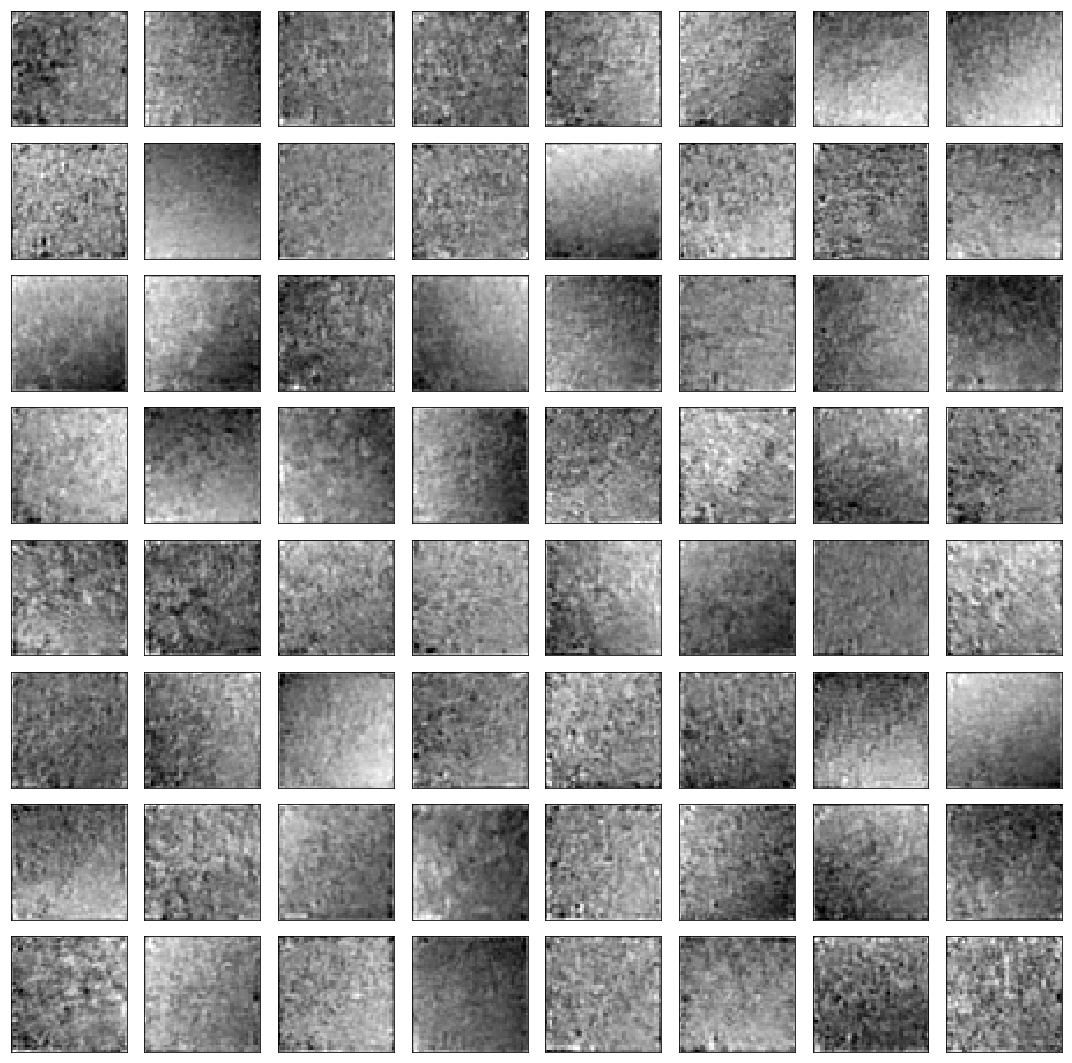

In [37]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'coord_conv_9', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 8, 8, figsize=(15,15))

Shape of feature maps: (1, 100, 100, 32)
Number of feature maps in layer:  32


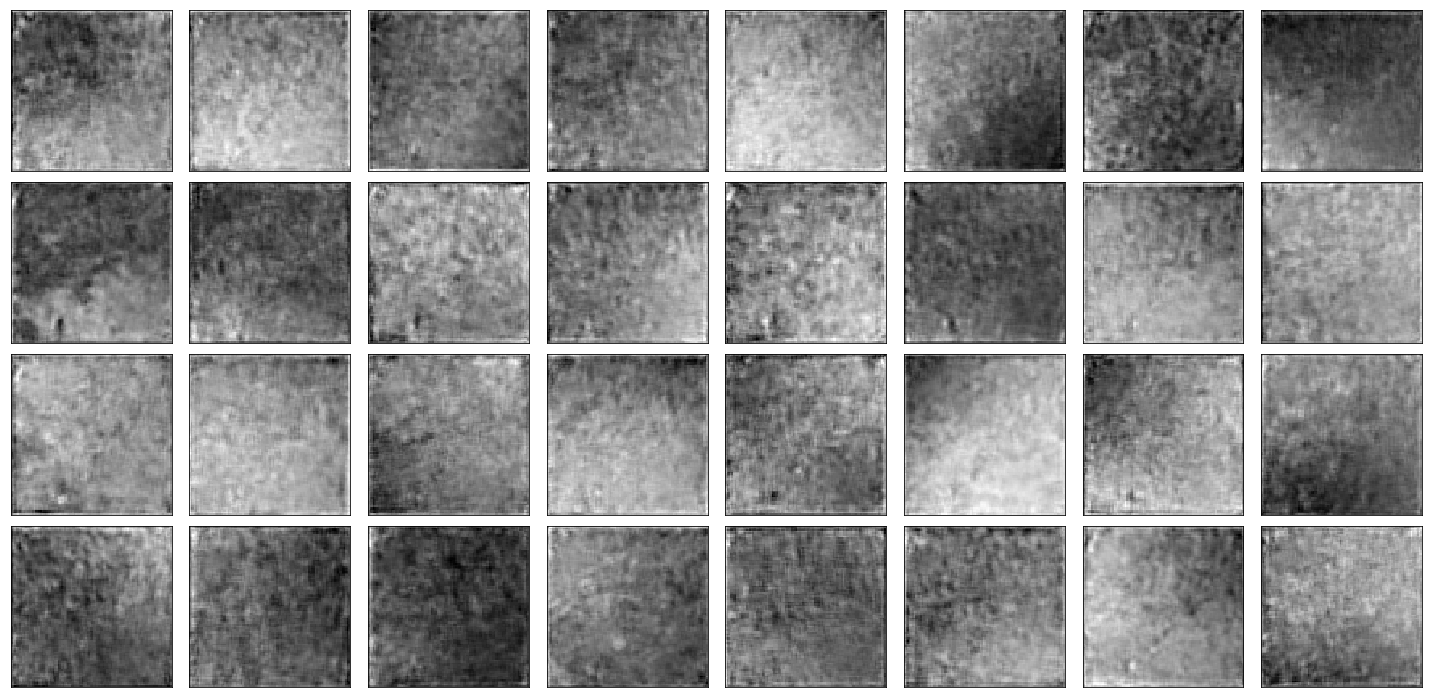

In [38]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'conv2d_36', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 4, 8, figsize=(20,10))

---

# Visualization Per-frame

In [39]:
one_hot_imgs_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_last_list', ver))
encoder_output_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'encoder_output_last_list', ver))
similarity_score_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'similarity_score_last_list', ver))
reconstruction_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'reconstruction_last_list', ver))

In [40]:

def multi_similarity_frame(one_hot_imgs_last_list_npy, similarity_score_last_list_npy, img_size, batch_size):
    '''
    Multiply similarity scores for every one hot pixel images and aggregate the one hot images into
    single frames
    
    @param one_hot_imgs_last_list_npy: .npy array of one hot images for the last epochs 
    @param similarity_score_last_list_npy: .npy array of similarity score for the last epochs
    @param img_size: image size
    @param batch_size: batch size
    
    return 
    tensor of one hot images multiplied with similarity scores for each images 
    '''
    count = 0
    onehot_list = []
    for one_hot in np.squeeze(one_hot_imgs_last_list_npy):
        if count!=len(similarity_score_last_list_npy): 
            for idx in range(count,count+batch_size): #loop through the similarity score for every batch_size increment
                sum_multi = np.zeros((img_size, img_size))
                for n in range(len(one_hot)): #n_neurons
                    multi = similarity_score_last_list_npy[idx, n]*one_hot[n]
                    sum_multi+=multi #sum all the one hot images
                onehot_list.append(sum_multi)
        count+=batch_size
        tensor = tf.convert_to_tensor(onehot_list, tf.float32)
    
    return tensor

In [41]:
tensor = multi_similarity_frame(one_hot_imgs_last_list_npy, similarity_score_last_list_npy, IMG_SIZE, BATCH_SIZE)

## Maximum Intensity Projection

In [96]:
# plt_captions = ['Original Coordinates', 'Maximum Intensity Projection']
# plt_row = [stack4plot(ori_one_hot_imgs_npy), np.where(np.sum(tensor, axis=0)<0.8, 0, 1.0)]

# plot_comparison(plt_row , plt_captions, n_col=len(plt_row), figsize = (15, 15))

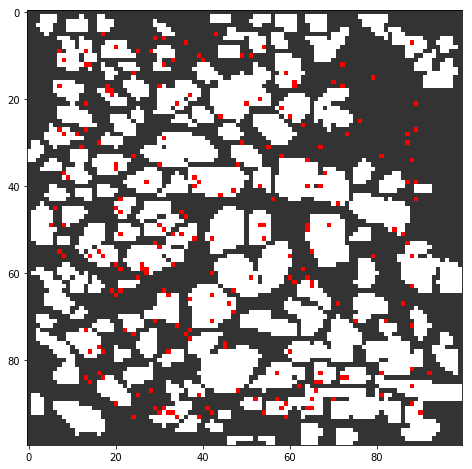

In [42]:
#define color
col = [(0.2, 0.2, 0.2),(1,1,1),(1,0,0)] 
cm = LinearSegmentedColormap.from_list('mylist', col, 3)  
#     #Bins for cmap
bounds=[0,1,5,10]
norm = BoundaryNorm(bounds, cm.N)

plt.figure(figsize=(8,8))
tensor_sum02 = np.where(np.sum(tensor, axis=0)<0.8, 0, 1.0)
roi_frame = overlapMasks02(roi_img, tensor_sum02)
plt.imshow(roi_frame, cmap = cm , norm = norm)
plt.show()

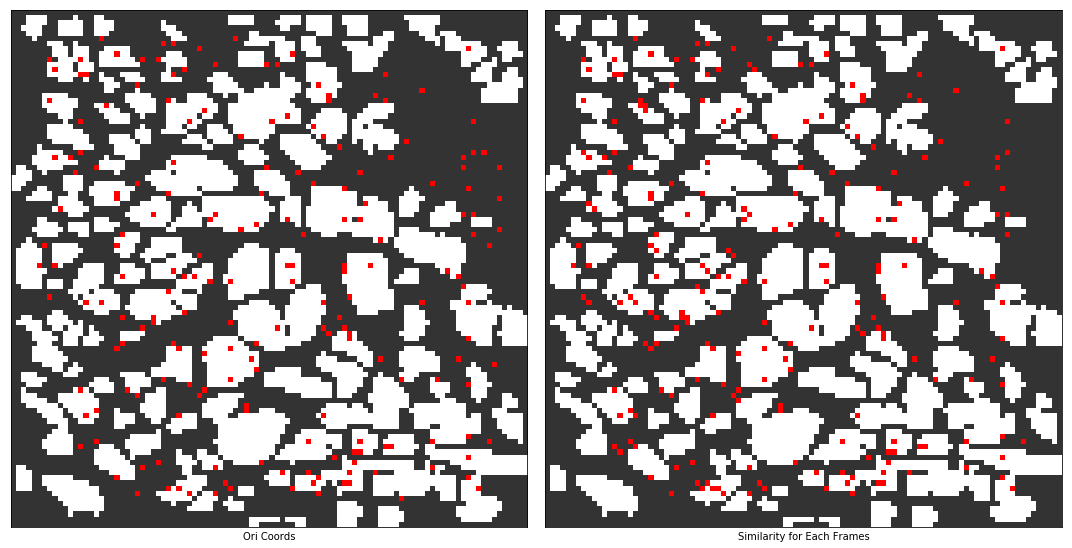

Counts:  213


In [43]:
#overlap mask with original coordinates 
roi_ori_mask = overlapMasks02(roi_img, stack4plot(ori_one_hot_imgs_npy))

captions_05 = ['Ori Coords', 'Similarity for Each Frames']
img_row05 = [roi_ori_mask, roi_frame]
plot_comparison(img_row05, captions_05, n_col=len(img_row05), figsize = (15, 15), cmap = cm, norm = norm)

activations_count = np.count_nonzero(tensor_sum02!=0)
print("Counts: ", activations_count)